# PaddleOCR with OpenVINO

This demo shows how to run PaddleOCR (Lite) model on OpenVINO natively. Instead of exporting the PaddlePaddle model to ONNX and then create the Intermediate Representation (IR) format through OpenVINO optimizer, we can now read direct from the Paddle Model without any conversions.

Authors: 
Zhuo Wu, PhD (OpenVINO Edge AI Software Evangelist - Intel)

## Run Paddle Detection with OpenVINO

In [87]:
import os, os.path
import sys
import json
import urllib.request
import cv2
import numpy as np
import paddle
import math
import time

from openvino.inference_engine import IENetwork, IECore, ExecutableNetwork
from IPython import display
from PIL import Image, ImageDraw
import copy
import collections

import logging
import imghdr
from shapely.geometry import Polygon
import pyclipper

### Load the image

In [88]:
image_file = "handwritten_simplified_chinese_test1.jpg"
#image_file = "/home/wu/PaddleOCR/doc/imgs/11.jpg"

In [89]:
def image_preprocess(input_image, size):
    img = cv2.resize(input_image, (size,size))
    img = np.transpose(img, [2,0,1]) / 255
    img = np.expand_dims(img, 0)
    ##NormalizeImage: {mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225], is_scale: True}
    img_mean = np.array([0.485, 0.456,0.406]).reshape((3,1,1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3,1,1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

ii = cv2.imread(image_file)
test_image = image_preprocess(ii,640)

### Load the Network

In [90]:
start_time = time.time()

In [91]:
model_dir = "/home/wu/PaddleOCR/inference/ch_ppocr_mobile_v2.0_det_infer"
model_file_path = model_dir + "/inference.pdmodel"
params_file_path = model_dir + "/inference.pdiparams"

In [92]:
ie = IECore()
net = ie.read_network(model_file_path)

In [93]:
device = 'CPU'
# pdmodel might be dynamic shape, this will reshape based on the input
input_key = list(net.input_info.items())[0][0] # 'inputs'
net.reshape({input_key: test_image.shape})

In [94]:
exec_net = ie.load_network(net, 'CPU') 
assert isinstance(exec_net, ExecutableNetwork)

In [95]:
#perform the inference step
output = exec_net.infer({input_key: test_image})
result_ie = list(output.values())

### Visualize the result for PaddleDetection

In [96]:
ori_im = ii.copy()
data = {'image': ii}

In [97]:
def DetResizeForTest(data):

    img = data['image']
    src_h, src_w, _ = img.shape

    ####resize image to a size multiple of 32 which is required by the network args:
    ###img(array): array with shape [h, w, c]

    limit_side_len = 960
    h, w, c = img.shape

    # limit the max side
    if max(h, w) > limit_side_len:
        if h > w:
            ratio = float(limit_side_len) / h
        else:
            ratio = float(limit_side_len) / w
    else:
        ratio = 1.

    resize_h = int(h * ratio)
    resize_w = int(w * ratio)

    resize_h = max(int(round(resize_h / 32) * 32), 32)
    resize_w = max(int(round(resize_w / 32) * 32), 32)

    try:
        if int(resize_w) <= 0 or int(resize_h) <= 0:
            return None, (None, None)
        img = cv2.resize(img, (int(resize_w), int(resize_h)))
    except:
        print(img.shape, resize_w, resize_h)
        sys.exit(0)
    ratio_h = resize_h / float(h)
    ratio_w = resize_w / float(w)
        
    data['image'] = img
    data['shape'] = np.array([src_h, src_w, ratio_h, ratio_w])
    return data

In [98]:
def NormalizeImage(data):
    """ normalize image such as substract mean, divide std
    """

    scale =  1.0 / 255.0
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    shape = (1, 1, 3)
    mean = np.array(mean).reshape(shape).astype('float32')
    std = np.array(std).reshape(shape).astype('float32')

    img = data['image']
    from PIL import Image
    if isinstance(img, Image.Image):
        img = np.array(img)

    assert isinstance(img,np.ndarray), "invalid input 'img' in NormalizeImage"
    data['image'] = (img.astype('float32') * scale - mean) / std
    return data

In [99]:
data_resize = DetResizeForTest(data)
data_norm = NormalizeImage(data_resize)
data_list = []
keep_keys =  ['image', 'shape']
for key in keep_keys:
    data_list.append(data[key])
img, shape_list = data_list

In [100]:
def unclip(box):
        unclip_ratio = 2.0
        poly = Polygon(box)
        distance = poly.area * unclip_ratio / poly.length
        offset = pyclipper.PyclipperOffset()
        offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        expanded = np.array(offset.Execute(distance))
        return expanded

In [101]:
def get_mini_boxes(contour):
        bounding_box = cv2.minAreaRect(contour)
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_1, index_2, index_3, index_4 = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_1 = 0
            index_4 = 1
        else:
            index_1 = 1
            index_4 = 0
        if points[3][1] > points[2][1]:
            index_2 = 2
            index_3 = 3
        else:
            index_2 = 3
            index_3 = 2

        box = [
            points[index_1], points[index_2], points[index_3], points[index_4]
        ]
        return box, min(bounding_box[1])

In [102]:
 def box_score_fast(bitmap, _box):
        '''
        box_score_fast: use bbox mean score as the mean score
        '''
        h, w = bitmap.shape[:2]
        box = _box.copy()
        xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int), 0, w - 1)
        xmax = np.clip(np.ceil(box[:, 0].max()).astype(np.int), 0, w - 1)
        ymin = np.clip(np.floor(box[:, 1].min()).astype(np.int), 0, h - 1)
        ymax = np.clip(np.ceil(box[:, 1].max()).astype(np.int), 0, h - 1)

        mask = np.zeros((ymax - ymin + 1, xmax - xmin + 1), dtype=np.uint8)
        box[:, 0] = box[:, 0] - xmin
        box[:, 1] = box[:, 1] - ymin
        cv2.fillPoly(mask, box.reshape(1, -1, 2).astype(np.int32), 1)
        return cv2.mean(bitmap[ymin:ymax + 1, xmin:xmax + 1], mask)[0]

In [103]:
def boxes_from_bitmap(pred, _bitmap, dest_width, dest_height):
        '''
        _bitmap: single map with shape (1, H, W),
                whose values are binarized as {0, 1}
        '''

        bitmap = _bitmap
        height, width = bitmap.shape

        outs = cv2.findContours((bitmap * 255).astype(np.uint8), cv2.RETR_LIST,
                                cv2.CHAIN_APPROX_SIMPLE)
        if len(outs) == 3:
            img, contours, _ = outs[0], outs[1], outs[2]
        elif len(outs) == 2:
            contours, _ = outs[0], outs[1]

        num_contours = min(len(contours), 1000)
        
        score_mode = "fast"

        boxes = []
        scores = []
        for index in range(num_contours):
            contour = contours[index]
            points, sside = get_mini_boxes(contour)
            if sside < 3:
                continue
            points = np.array(points)
            if score_mode == "fast":
                score = box_score_fast(pred, points.reshape(-1, 2))
            else:
                score = box_score_slow(pred, contour)
            if 0.7 > score:
                continue

            box = unclip(points).reshape(-1, 1, 2)
            box, sside = get_mini_boxes(box)
            if sside < 3 + 2:
                continue
            box = np.array(box)

            box[:, 0] = np.clip(
                np.round(box[:, 0] / width * dest_width), 0, dest_width)
            box[:, 1] = np.clip(
                np.round(box[:, 1] / height * dest_height), 0, dest_height)
            boxes.append(box.astype(np.int16))
            scores.append(score)
        return np.array(boxes, dtype=np.int16), scores

In [104]:
def filter_tag_det_res(dt_boxes, image_shape):
        img_height, img_width = image_shape[0:2]
        dt_boxes_new = []
        for box in dt_boxes:
            box = order_points_clockwise(box)
            box = clip_det_res(box, img_height, img_width)
            rect_width = int(np.linalg.norm(box[0] - box[1]))
            rect_height = int(np.linalg.norm(box[0] - box[3]))
            if rect_width <= 3 or rect_height <= 3:
                continue
            dt_boxes_new.append(box)
        dt_boxes = np.array(dt_boxes_new)
        return dt_boxes


def order_points_clockwise(pts):
    """
    reference from: https://github.com/jrosebr1/imutils/blob/master/imutils/perspective.py
    # sort the points based on their x-coordinates
    """
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost

    rect = np.array([tl, tr, br, bl], dtype="float32")
    return rect

def clip_det_res(points, img_height, img_width):
    for pno in range(points.shape[0]):
        points[pno, 0] = int(min(max(points[pno, 0], 0), img_width - 1))
        points[pno, 1] = int(min(max(points[pno, 1], 0), img_height - 1))
    return points

In [105]:
shape_list = np.expand_dims(shape_list, axis=0)
pred = result_ie[0]      
if isinstance(pred, paddle.Tensor):
    pred = pred.numpy()
pred = pred[:, 0, :, :]
segmentation = pred > 0.3

boxes_batch = []
for batch_index in range(pred.shape[0]):
    src_h, src_w, ratio_h, ratio_w = shape_list[batch_index]

    mask = segmentation[batch_index]
    boxes, scores = boxes_from_bitmap(pred[batch_index], mask,src_w, src_h)

    boxes_batch.append({'points': boxes})

post_result = boxes_batch
dt_boxes = post_result[0]['points']

In [106]:
ori_im = ii
dt_boxes = filter_tag_det_res(dt_boxes, ori_im.shape)

### Visulaize detection results

In [107]:
model_dir = "/home/wu/PaddleOCR/inference/ch_ppocr_mobile_v2.0_det_infer"
model_file_path = model_dir + "/inference.pdmodel"
params_file_path = model_dir + "/inference.pdiparams"

In [108]:
def draw_text_det_res(dt_boxes, img_path):
    src_im = cv2.imread(img_path)
    for box in dt_boxes:
        box = np.array(box).astype(np.int32).reshape(-1, 2)
        cv2.polylines(src_im, [box], True, color=(255, 255, 0), thickness=2)
    return src_im

In [109]:
src_im = draw_text_det_res(dt_boxes, image_file)
img_name_pure = os.path.split(image_file)[-1]
img_path = "det_res_{}".format(img_name_pure)
cv2.imwrite(img_path, src_im)

True

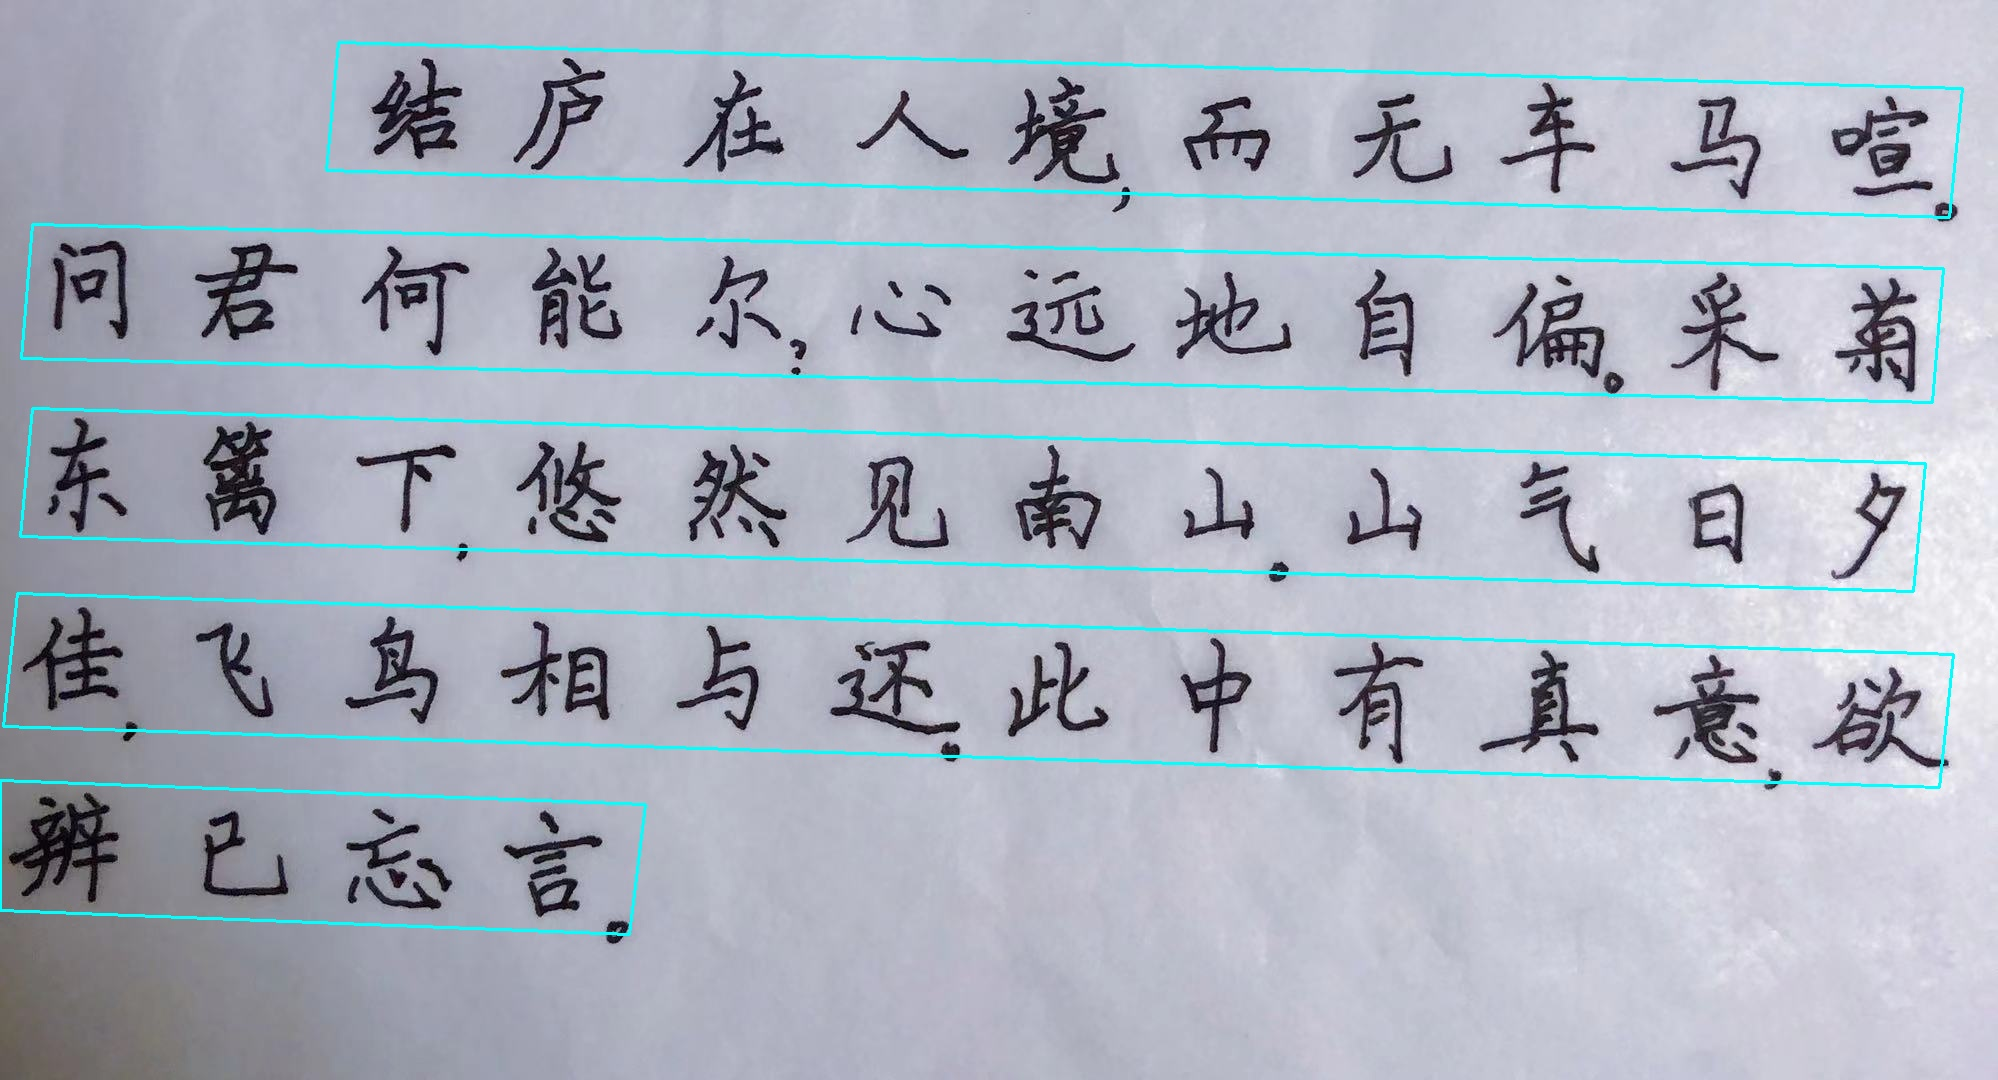

In [110]:
_,ret_array = cv2.imencode('.jpg', src_im) 
i = display.Image(data=ret_array)            
display.display(i)

### Processing detection results for Recognition

In [111]:
def sorted_boxes(dt_boxes):
    """
    Sort text boxes in order from top to bottom, left to right
    args:
        dt_boxes(array):detected text boxes with shape [4, 2]
    return:
        sorted boxes(array) with shape [4, 2]
    """
    num_boxes = dt_boxes.shape[0]
    sorted_boxes = sorted(dt_boxes, key=lambda x: (x[0][1], x[0][0]))
    _boxes = list(sorted_boxes)

    for i in range(num_boxes - 1):
        if abs(_boxes[i + 1][0][1] - _boxes[i][0][1]) < 10 and \
                (_boxes[i + 1][0][0] < _boxes[i][0][0]):
            tmp = _boxes[i]
            _boxes[i] = _boxes[i + 1]
            _boxes[i + 1] = tmp
    return _boxes

In [112]:
def get_rotate_crop_image(img, points):
    '''
    img_height, img_width = img.shape[0:2]
    left = int(np.min(points[:, 0]))
    right = int(np.max(points[:, 0]))
    top = int(np.min(points[:, 1]))
    bottom = int(np.max(points[:, 1]))
    img_crop = img[top:bottom, left:right, :].copy()
    points[:, 0] = points[:, 0] - left
    points[:, 1] = points[:, 1] - top
    '''
    assert len(points) == 4, "shape of points must be 4*2"
    img_crop_width = int(
        max(
            np.linalg.norm(points[0] - points[1]),
            np.linalg.norm(points[2] - points[3])))
    img_crop_height = int(
        max(
            np.linalg.norm(points[0] - points[3]),
            np.linalg.norm(points[1] - points[2])))
    pts_std = np.float32([[0, 0], [img_crop_width, 0],
                          [img_crop_width, img_crop_height],
                          [0, img_crop_height]])
    M = cv2.getPerspectiveTransform(points, pts_std)
    dst_img = cv2.warpPerspective(
        img,
        M, (img_crop_width, img_crop_height),
        borderMode=cv2.BORDER_REPLICATE,
        flags=cv2.INTER_CUBIC)
    dst_img_height, dst_img_width = dst_img.shape[0:2]
    if dst_img_height * 1.0 / dst_img_width >= 1.5:
        dst_img = np.rot90(dst_img)
    return dst_img

In [113]:
dt_boxes = sorted_boxes(dt_boxes)
img_crop_list = []

for bno in range(len(dt_boxes)):
    tmp_box = copy.deepcopy(dt_boxes[bno])
    img_crop = get_rotate_crop_image(ori_im, tmp_box)
    img_crop_list.append(img_crop)

## Run Paddle Recognition with OpenVINO

### Preprocess the Image for Paddle Recognition

In [114]:
def resize_norm_img(img, max_wh_ratio):
        rec_image_shape = [3, 32, 320]
        imgC, imgH, imgW = rec_image_shape
        assert imgC == img.shape[2]
        character_type = "ch"
        if character_type == "ch":
            imgW = int((32 * max_wh_ratio))
        h, w = img.shape[:2]
        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

### Define postprocess for Paddle Recognition results 

In [115]:
import string
from paddle.nn import functional as F


class BaseRecLabelDecode(object):
    """ Convert between text-label and text-index """

    def __init__(self,
                 character_dict_path=None,
                 character_type='ch',
                 use_space_char=False):
        support_character_type = [
            'ch', 'en', 'EN_symbol', 'french', 'german', 'japan', 'korean',
            'it', 'xi', 'pu', 'ru', 'ar', 'ta', 'ug', 'fa', 'ur', 'rs', 'oc',
            'rsc', 'bg', 'uk', 'be', 'te', 'ka', 'chinese_cht', 'hi', 'mr',
            'ne', 'EN', 'latin', 'arabic', 'cyrillic', 'devanagari'
        ]
        assert character_type in support_character_type, "Only {} are supported now but get {}".format(
            support_character_type, character_type)

        self.beg_str = "sos"
        self.end_str = "eos"

        if character_type == "en":
            self.character_str = "0123456789abcdefghijklmnopqrstuvwxyz"
            dict_character = list(self.character_str)
        elif character_type == "EN_symbol":
            # same with ASTER setting (use 94 char).
            self.character_str = string.printable[:-6]
            dict_character = list(self.character_str)
        elif character_type in support_character_type:
            self.character_str = []
            assert character_dict_path is not None, "character_dict_path should not be None when character_type is {}".format(
                character_type)
            with open(character_dict_path, "rb") as fin:
                lines = fin.readlines()
                for line in lines:
                    line = line.decode('utf-8').strip("\n").strip("\r\n")
                    self.character_str.append(line)
            if use_space_char:
                self.character_str.append(" ")
            dict_character = list(self.character_str)

        else:
            raise NotImplementedError
        self.character_type = character_type
        dict_character = self.add_special_char(dict_character)
        self.dict = {}
        for i, char in enumerate(dict_character):
            self.dict[char] = i
        self.character = dict_character

    def add_special_char(self, dict_character):
        return dict_character

    def decode(self, text_index, text_prob=None, is_remove_duplicate=False):
        """ convert text-index into text-label. """
        result_list = []
        ignored_tokens = self.get_ignored_tokens()
        batch_size = len(text_index)
        for batch_idx in range(batch_size):
            char_list = []
            conf_list = []
            for idx in range(len(text_index[batch_idx])):
                if text_index[batch_idx][idx] in ignored_tokens:
                    continue
                if is_remove_duplicate:
                    # only for predict
                    if idx > 0 and text_index[batch_idx][idx - 1] == text_index[
                            batch_idx][idx]:
                        continue
                char_list.append(self.character[int(text_index[batch_idx][
                    idx])])
                if text_prob is not None:
                    conf_list.append(text_prob[batch_idx][idx])
                else:
                    conf_list.append(1)
            text = ''.join(char_list)
            result_list.append((text, np.mean(conf_list)))
        return result_list

    def get_ignored_tokens(self):
        return [0]  # for ctc blank

In [116]:
class CTCLabelDecode(BaseRecLabelDecode):
    """ Convert between text-label and text-index """

    def __init__(self,
                 character_dict_path=None,
                 character_type='ch',
                 use_space_char=False,
                 **kwargs):
        super(CTCLabelDecode, self).__init__(character_dict_path,
                                             character_type, use_space_char)

    def __call__(self, preds, label=None, *args, **kwargs):
        if isinstance(preds, paddle.Tensor):
            preds = preds.numpy()
        preds_idx = preds.argmax(axis=2)
        preds_prob = preds.max(axis=2)
        text = self.decode(preds_idx, preds_prob, is_remove_duplicate=True)
        if label is None:
            return text
        label = self.decode(label)
        return text, label

    def add_special_char(self, dict_character):
        dict_character = ['blank'] + dict_character
        return dict_character

In [117]:
postprocess_params = {
            'name': 'CTCLabelDecode',
            "character_type": "ch",
            "character_dict_path": "/home/wu/PaddleOCR/ppocr/utils/ppocr_keys_v1.txt",
            "use_space_char": True
        }

In [118]:
import copy

def build_post_process(config):

    config = copy.deepcopy(config)
    module_name = config.pop('name')
    module_class = eval(module_name)(**config)
    return module_class

### Load the Network and Run the Inference

In [119]:
model_dir = "/home/wu/PaddleOCR/inference/ch_ppocr_mobile_v2.0_rec_infer"
model_file_path = model_dir + "/inference.pdmodel"
params_file_path = model_dir + "/inference.pdiparams"

ie = IECore()
print(model_file_path)
net = ie.read_network(model_file_path)

/home/wu/PaddleOCR/inference/ch_ppocr_mobile_v2.0_rec_infer/inference.pdmodel


### Recognition starts from here

In [120]:
img_num = len(img_crop_list)
# Calculate the aspect ratio of all text bars
width_list = []
for img in img_crop_list:
    width_list.append(img.shape[1] / float(img.shape[0]))
# Sorting can speed up the recognition process
indices = np.argsort(np.array(width_list))
rec_res = [['', 0.0]] * img_num
rec_batch_num = 6
batch_num = rec_batch_num
st = time.time()

In [121]:
for beg_img_no in range(0, img_num, batch_num):
    end_img_no = min(img_num, beg_img_no + batch_num)
    norm_img_batch = []
    max_wh_ratio = 0
    for ino in range(beg_img_no, end_img_no):
        h, w = img_crop_list[indices[ino]].shape[0:2]
        wh_ratio = w * 1.0 / h
        max_wh_ratio = max(max_wh_ratio, wh_ratio)
    for ino in range(beg_img_no, end_img_no):
        norm_img = resize_norm_img(img_crop_list[indices[ino]],max_wh_ratio)
        norm_img = norm_img[np.newaxis, :]
        norm_img_batch.append(norm_img)

    norm_img_batch = np.concatenate(norm_img_batch)
    norm_img_batch = norm_img_batch.copy()
    
    # pdmodel might be dynamic shape, this will reshape based on the input
    input_key = list(net.input_info.items())[0][0] # 'inputs'
    net.reshape({input_key: norm_img_batch.shape})

    #load the network on CPU
    exec_net = ie.load_network(net, 'CPU') 
    assert isinstance(exec_net, ExecutableNetwork)

    for index in range(len(norm_img_batch)):
        output = exec_net.infer({input_key: norm_img_batch})
    result_ie = list(output.values())
    preds = result_ie[0]
    postprocess_op = build_post_process(postprocess_params)
    rec_result = postprocess_op(preds)
    for rno in range(len(rec_result)):
        rec_res[indices[beg_img_no + rno]] = rec_result[rno]

In [122]:
stop_time = time.time()

In [123]:
print(rec_res)

[('结庐在人境品无车马喧', 0.7947357), ('问君何能尔心远地自偏采前', 0.78279454), ('东鹤下您然见南山山气日夕', 0.8802729), ('佳飞鸟相与还此中有真意欲', 0.8675663), ('辩已意言', 0.38597608)]


In [124]:
processing_time = stop_time - start_time
print(processing_time)

0.5888919830322266
